In [1]:
import geopandas as gpd
import pandas as pd

import json
import osm2geojson
import requests

import datetime

import matplotlib.pyplot as plt


import numpy as np
from tqdm import tqdm

In [2]:
#alt.data_transformers.enable("vegafusion")

In [3]:
#This Script gets a geometry from osm via overpass and gets a osm streetnetwork incl history for this geometry.
# then a virtual street network for each year (1st of Jan) is created to vizualize via altair.

In [4]:
#shape_name= "Neukölln"
#shape_name= "Berlin"
shape_name= "Deutschland"
shape_name_str=shape_name.replace("ö","oe")

# read poly

In [5]:
gdf_osm_shape_poly = gpd.read_file("osm_files/"+ shape_name_str+ "_poly_shape.geojson")

<Axes: >

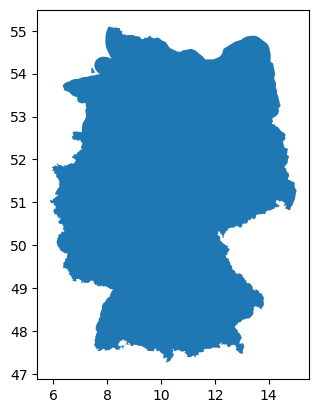

In [6]:
gdf_osm_shape_poly.plot()

# get network (2017 & 2024)

In [7]:
#osm_roads_all = gpd.read_file("osm_files/"+ shape_name_str+ "_roads_allYears.gpkg")

In [11]:
#osm_roads_all.to_parquet("osm_files/"+ shape_name_str+ "_roads_allYears.parquet")
osm_roads_all = gpd.read_parquet("osm_files/"+ shape_name_str+ "_roads_allYears.parquet")

In [12]:
osm_roads_all=osm_roads_all[osm_roads_all.maxspeed.isin(["30","50"])].copy()

In [10]:
#osm_roads_all.year.unique()

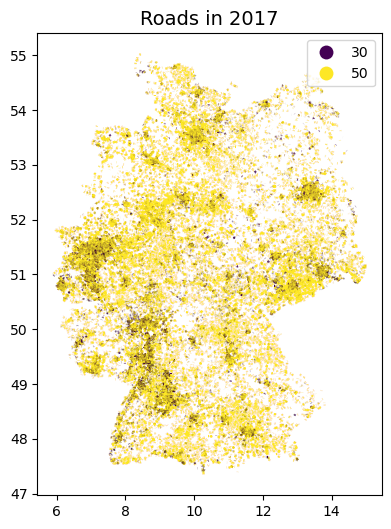

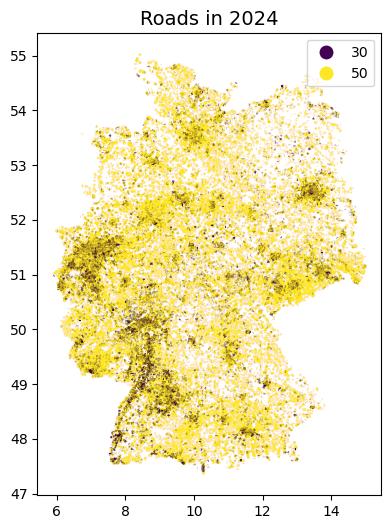

In [11]:
# plot the roads
for y in osm_roads_all.year.unique():
    
    # Create a plot with color based on a column (e.g., 'road_type')
    ax = osm_roads_all[osm_roads_all.year == y].plot(
        column="maxspeed",  # Change this to the column you want for color
        cmap="viridis",  # Change color map if needed
        legend=True,  # Show color legend
        figsize=(10, 6)
    )
    
    # Add a title
    plt.title(f"Roads in {y}", fontsize=14)
    
    # Show plot
    plt.show()

### monitor length

In [13]:
df_len=osm_roads_all.copy()

# Ensure the GeoDataFrame uses a projected CRS (for accurate length calculation)
if df_len.crs is None or df_len.crs.is_geographic:
    df_len = df_len.to_crs(epsg=25832)  # Convert to metric CRS (UTM for Germany)

# Compute the length of each line
df_len["length"] = df_len.geometry.length

# Group by year and maxspeed, then sum the lengths
length_summary = df_len.groupby(["year", "maxspeed"])["length"].sum().reset_index()

# Compute total length per year
total_length_per_year = df_len.groupby("year")["length"].sum().reset_index()
total_length_per_year["maxspeed"] = "Total"  # Mark it as total for merging later

# Merge total length data with the main summary
length_summary = pd.concat([length_summary, total_length_per_year], ignore_index=True)

# Convert length to kilometers for better readability
length_summary["length_km"] = length_summary["length"] / 1000

# Compute relative change for each maxspeed and total
length_summary["relative_change"] = length_summary.groupby("maxspeed")["length"].pct_change() * 100

In [14]:
length_summary

,year,maxspeed,length,length_km,relative_change
0,2017,30,4.250121e+06,4250.121312,NaN
1,2017,50,4.981491e+07,49814.905351,NaN
2,2024,30,6.428255e+06,6428.254627,51.248733
3,2024,50,6.225797e+07,62257.967306,24.978592
4,2017,Total,5.406503e+07,54065.026663,NaN
5,2024,Total,6.868622e+07,68686.221932,27.043722


In [15]:
osm_roads_all["maxspeed:conditional"].value_counts()

maxspeed:conditional
30 @ (22:00-06:00)                              4584
30 @ (Mo-Fr 07:00-17:00)                        1420
30 @ (Mo-Fr 07:00-18:00)                         630
30 @ (Mo-Fr 06:00-18:00)                         546
30 @ (00:00-06:00,22:00-24:00)                   435
                                                ... 
30 @ (Freibadsaisson)                              1
30 @(06:00-22:00)                                  1
30 @ (Mo - Fr 06:00 - 17:00)                       1
30@Mo-Sa 06:00-19:00                               1
30 @ (Mo-Fr 06:00-08:00,13:00-16:00; PH off)       1
Name: count, Length: 564, dtype: int64

In [16]:
df_len = osm_roads_all.copy()

# Ensure correct CRS for length calculation
if df_len.crs is None or df_len.crs.is_geographic:
    df_len = df_len.to_crs(epsg=25832)  # Convert to metric CRS (UTM for Germany)

# Compute length of each road segment
df_len["length"] = df_len.geometry.length

# **🚀 Step 1: Filter roads with maxspeed = 50 and conditional speed = 30 @ ...**
df_conditional_30 = df_len[
    (df_len["maxspeed"] == "50") & 
    (df_len["maxspeed:conditional"].notna()) & 
    (df_len["maxspeed:conditional"].str.startswith("30 @"))
].copy()

# **🚀 Step 2: Compute total length for roads with conditional maxspeed**
length_conditional_30 = df_conditional_30.groupby("year")["length"].sum().reset_index()
length_conditional_30.rename(columns={"length": "length_conditional_30"}, inplace=True)

# **🚀 Step 3: Compute total length for all maxspeed = 50 roads**
length_50 = df_len[df_len["maxspeed"] == "50"].groupby("year")["length"].sum().reset_index()
length_50.rename(columns={"length": "length_total_50"}, inplace=True)

# **🚀 Step 4: Merge both summaries together**
length_summary = length_50.merge(length_conditional_30, on="year", how="left").fillna(0)

# Convert to kilometers
length_summary["length_total_50_km"] = length_summary["length_total_50"] / 1000
length_summary["length_conditional_30_km"] = length_summary["length_conditional_30"] / 1000

# **🚀 Step 5: Compute percentage of roads affected by conditional speed limits**
length_summary["conditional_30_ratio"] = (length_summary["length_conditional_30"] / length_summary["length_total_50"]) * 100

# **🚀 Step 6: Compute relative change of conditional speed limits over years**
length_summary["relative_change_conditional_30"] = length_summary["length_conditional_30"].pct_change() * 100




In [17]:
length_summary

,year,length_total_50,length_conditional_30,length_total_50_km,length_conditional_30_km,conditional_30_ratio,relative_change_conditional_30
0,2017,4.981491e+07,2.849556e+05,49814.905351,284.955590,0.572029,NaN
1,2024,6.225797e+07,1.094280e+06,62257.967306,1094.280113,1.757655,284.017774


In [18]:
#osm_roads_all_2017=osm_roads_all[osm_roads_all.year=="2017"].copy()

In [19]:
osm_roads_all_25832=osm_roads_all.to_crs(25832)

In [20]:
osm_roads_all_25832["length"] = osm_roads_all_25832.geometry.length

In [21]:
osm_roads_all_25832

,highway,maxspeed,maxspeed:conditional,id,year,geometry,length
2,secondary,50,None,122,2017,"MULTILINESTRING ((831653.548 5663833.164, 8316...",18.252307
3,tertiary,50,None,123,2017,"MULTILINESTRING ((832886.265 5664175.265, 8328...",388.756268
4,primary,50,None,1978,2017,"MULTILINESTRING ((560704.374 5924994.052, 5607...",158.033811
7,secondary,50,None,2176,2017,"MULTILINESTRING ((699929.378 5309621.261, 6999...",218.020824
8,secondary,50,None,2178,2017,"MULTILINESTRING ((699701.916 5310219.058, 6996...",32.794653
...,...,...,...,...,...,...,...
1984562,tertiary,50,None,1236125759,2024,"MULTILINESTRING ((492258.021 5755215.876, 4922...",31.032316
1984563,tertiary,50,None,1236125760,2024,"MULTILINESTRING ((492297.051 5755150.053, 4923...",17.236885
1984564,tertiary,50,None,1236125761,2024,"MULTILINESTRING ((492309.431 5755229.798, 4923...",19.256197
1984565,tertiary,50,None,1236125762,2024,"MULTILINESTRING ((492298.815 5755189.084, 4922...",22.493363


In [22]:
# Grouping by 'highway' and 'maxspeed' and summing up the length
grouped_df = osm_roads_all_25832.groupby(["highway", "maxspeed","year"], as_index=False)["length"].sum()
grouped_df["length"]=grouped_df["length"]/1000
grouped_df

,highway,maxspeed,year,length
0,primary,30,2017,195.236347
1,primary,30,2024,404.430590
2,primary,50,2017,8523.475370
3,primary,50,2024,9218.282589
4,primary_link,30,2017,5.787192
5,primary_link,30,2024,10.823527
6,primary_link,50,2017,216.861603
7,primary_link,50,2024,256.837588
8,secondary,30,2017,1093.499525
9,secondary,30,2024,1744.727914


In [23]:
import altair as alt
from vega_datasets import data

source = grouped_df

alt.Chart(source).mark_bar().encode(
    x='highway',
    y='sum(length)',
    color='maxspeed',
    facet="year"
)

alt.Chart(...)

In [50]:

# Pivoting the data correctly to compare years
df_pivot = grouped_df.pivot(index=["highway", "maxspeed"], columns="year", values="length").reset_index()
df_pivot=df_pivot.rename(columns={"2017": "length_2017", "2024": "length_2024"})
# Calculating relative change ((new - old) / old) * 100
df_pivot["relative_change"] = ((df_pivot["length_2024"] - df_pivot["length_2017"]) / df_pivot["length_2017"]) * 100

In [51]:
df_pivot["absolute_change"]= df_pivot["length_2024"] - df_pivot["length_2017"]

In [52]:
df_pivot

year,highway,maxspeed,length_2017,length_2024,relative_change,absolute_change
0,primary,30,195.236347,404.430590,107.149230,209.194242
1,primary,50,8523.475370,9218.282589,8.151689,694.807219
2,primary_link,30,5.787192,10.823527,87.025542,5.036335
3,primary_link,50,216.861603,256.837588,18.433870,39.975985
4,secondary,30,1093.499525,1744.727914,59.554520,651.228389
5,secondary,50,22632.494789,26868.155677,18.714954,4235.660888
6,secondary_link,30,6.485932,10.588129,63.247597,4.102196
7,secondary_link,50,126.457460,214.643921,69.736068,88.186461
8,tertiary,30,2944.631875,4251.670504,44.387166,1307.038629
9,tertiary,50,18272.584780,25604.216476,40.123670,7331.631695


In [27]:
source = df_pivot

alt.Chart(source, title="relative_change").mark_bar().encode(
    x='highway',
    y='relative_change',
    color='maxspeed',
    facet="maxspeed"
)

alt.Chart(...)

In [28]:
alt.Chart(source, title="absolute_change").mark_bar().encode(
    x='highway',
    y='absolute_change',
    color='maxspeed',
    facet="maxspeed"
)

alt.Chart(...)

# Unfälle

In [29]:

#accidents = gpd.read_file(r"accident_data/accidents_germany_2017-2023_si.gpkg",
#                      mask=gdf_osm_shape_poly)



In [31]:
#accidents.to_parquet(r"accident_data/accidents_germany_2017-2023_si.parquet")
accidents = gpd.read_parquet(r"accident_data/accidents_germany_2017-2023_si.parquet")

In [32]:
accidents

,OBJECTID,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,...,IstPKW,IstFuss,IstKrad,IstSonstig,LICHT,USTRZUSTAND,IstGkfz,OID_,PLST,geometry
0,1.0,1,0,55,12,2017,1,5,6,2,...,1,0,0,0,2,2,NaN,NaN,NaN,POINT (10.60903 54.15315)
1,2.0,1,0,60,53,2017,1,6,6,3,...,0,1,0,1,2,1,NaN,NaN,NaN,POINT (10.2515 53.86555)
2,3.0,1,0,61,11,2017,1,18,6,3,...,1,0,0,0,2,1,NaN,NaN,NaN,POINT (9.34834 54.0629)
3,4.0,1,0,55,42,2017,1,12,7,3,...,1,0,0,0,0,0,NaN,NaN,NaN,POINT (10.77041 53.9693)
4,5.0,1,0,62,60,2017,1,8,6,3,...,1,0,0,0,0,1,NaN,NaN,NaN,POINT (10.23148 53.55668)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677815,NaN,16,0,51,0,2023,11,13,6,3,...,0,0,0,0,0,0,0.0,269044.0,2.0,POINT (11.11681 50.99175)
1677816,NaN,16,0,67,89,2023,11,9,3,2,...,0,0,1,0,0,1,0.0,269045.0,2.0,POINT (10.74922 50.90326)
1677817,NaN,16,0,66,42,2023,11,14,4,3,...,0,1,0,0,0,1,0.0,269046.0,2.0,POINT (10.39856 50.57154)
1677818,NaN,16,0,55,0,2023,11,10,5,3,...,0,0,0,0,0,1,0.0,269047.0,2.0,POINT (11.33058 50.98586)


In [34]:
#accidents.columns

In [35]:
# nur schwere
#accidents=accidents[accidents["UKATEGORIE"]!=3]

In [33]:
accidents=accidents[["UJAHR","UKATEGORIE","geometry"]].copy()

# Netz 2017 (Unfälle für 2017 je Maxspeed)


In [46]:

# create buffer for all 30 and all 50 streets in diffrent dfs
def createBuffer4net(df, buffer):
    df_buffer=df.copy()
    df_buffer=df_buffer.to_crs(25832)

    # diffrent buffers for 30 and 50
    df_buffer_30=df_buffer[df_buffer.maxspeed=="30"].copy()
    df_buffer_50=df_buffer[df_buffer.maxspeed=="50"].copy()
    
    
    df_buffer_30["geometry"]=df_buffer_30.buffer(buffer)
    df_buffer_50["geometry"]=df_buffer_50.buffer(buffer)
    
    return df_buffer_30,df_buffer_50
    

## join accidents to the buffered roads
def joinAcc2BufferedNet(df_net, df_acc):
    # Ensure both datasets have spatial indexes
    df_net.sindex
    df_acc.sindex
    
    # Faster alternative using a spatial join
    df_acc_clipped = gpd.sjoin(
    df_acc, df_net, how="inner", predicate="intersects"
    ).drop(columns=["index_right"])  # Remove unnecessary index column

    ## remove the one, that are in 2 roads
    df_acc_clipped = df_acc_clipped[~df_acc_clipped.index.duplicated(keep='first')]
    
    return df_acc_clipped



#___________________________

Acc2bufferedNet_grouped_allYears=pd.DataFrame()

net_years=["2017","2024"]

for y in net_years:
    print (y)
    if y=="2017":
        acc_year=2017
    if y=="2024":
        acc_year=2023
    
    osm_roads_all_year=osm_roads_all[osm_roads_all.year==str(y)].copy()

    # test with sample first
    #osm_roads_all_year=osm_roads_all_year[:10000].copy()

    print ("   buffer roads...")
    # prepare net, buffer of each maxspeed
    # ~ 40s for one year entire germany
    osm_roads_all_year_buffer_30,osm_roads_all_year_buffer_50=createBuffer4net(osm_roads_all_year, 10)
    print ("   buffer roads done.")


    # prepare accidents
    accidents_year=accidents[accidents.UJAHR.isin([acc_year])]
    accidents_year_25832=accidents_year.to_crs(25832)
    print ("   accidents prepared.")


    ## join accidents to the buffered roads
    Acc2bufferedNet_30=joinAcc2BufferedNet(osm_roads_all_year_buffer_30, accidents_year_25832)
    Acc2bufferedNet_50=joinAcc2BufferedNet(osm_roads_all_year_buffer_50, accidents_year_25832)
    print ("   join accidents to the buffered roads done.")

    ## beide df wegen zusammengefügt
    Acc2bufferedNet_all=pd.concat([Acc2bufferedNet_30,Acc2bufferedNet_50])

    
    ### in bspw. Kreuzungsbereichen können durch 10m buffer Unfälle jeweils zugefügt werden, diese uneindeutigen werden geflagged
    # Identifying duplicate indexes efficiently
    is_duplicated = Acc2bufferedNet_all.index.duplicated(keep=False)
    Acc2bufferedNet_all["eindeutig"] = np.where(is_duplicated, "no", "yes")

    # keep only the eindeudige
    Acc2bufferedNet_all=Acc2bufferedNet_all[Acc2bufferedNet_all.eindeutig=="yes"].copy()

    # Grouping by 'highway' and 'maxspeed' and counting the occurrences
    Acc2bufferedNet_grouped = Acc2bufferedNet_all.groupby(["highway", "maxspeed","UKATEGORIE"]).size().reset_index(name="count")
    Acc2bufferedNet_grouped["net_year"]=y
    Acc2bufferedNet_grouped_allYears=pd.concat([Acc2bufferedNet_grouped_allYears,Acc2bufferedNet_grouped])


2017
   buffer roads...
   buffer roads done.
   accidents prepared.
   join accidents to the buffered roads done.
2024
   buffer roads...
   buffer roads done.
   accidents prepared.
   join accidents to the buffered roads done.


In [53]:
Acc2bufferedNet_grouped_allYears

,highway,maxspeed,UKATEGORIE,count,net_year
0,primary,30,1,4,2017
1,primary,30,2,49,2017
2,primary,30,3,235,2017
3,primary,50,1,78,2017
4,primary,50,2,2483,2017
...,...,...,...,...,...
26,tertiary,50,3,25443,2024
27,tertiary_link,30,3,3,2024
28,tertiary_link,50,1,3,2024
29,tertiary_link,50,2,26,2024


## bring Acc2bufferedNet together with NetLengths

In [54]:
# getting the length from above
df_pivot

year,highway,maxspeed,length_2017,length_2024,relative_change,absolute_change
0,primary,30,195.236347,404.430590,107.149230,209.194242
1,primary,50,8523.475370,9218.282589,8.151689,694.807219
2,primary_link,30,5.787192,10.823527,87.025542,5.036335
3,primary_link,50,216.861603,256.837588,18.433870,39.975985
4,secondary,30,1093.499525,1744.727914,59.554520,651.228389
5,secondary,50,22632.494789,26868.155677,18.714954,4235.660888
6,secondary_link,30,6.485932,10.588129,63.247597,4.102196
7,secondary_link,50,126.457460,214.643921,69.736068,88.186461
8,tertiary,30,2944.631875,4251.670504,44.387166,1307.038629
9,tertiary,50,18272.584780,25604.216476,40.123670,7331.631695


In [58]:
Acc2bufferedNet_grouped_allYears

,highway,maxspeed,UKATEGORIE,count,net_year
0,primary,30,1,4,2017
1,primary,30,2,49,2017
2,primary,30,3,235,2017
3,primary,50,1,78,2017
4,primary,50,2,2483,2017
...,...,...,...,...,...
26,tertiary,50,3,25443,2024
27,tertiary_link,30,3,3,2024
28,tertiary_link,50,1,3,2024
29,tertiary_link,50,2,26,2024


In [60]:
Acc2bufferedNet_grouped_allYears[Acc2bufferedNet_grouped_allYears.net_year=="2017"]

,highway,maxspeed,UKATEGORIE,count,net_year
0,primary,30,1,4,2017
1,primary,30,2,49,2017
2,primary,30,3,235,2017
3,primary,50,1,78,2017
4,primary,50,2,2483,2017
5,primary,50,3,15123,2017
6,primary_link,30,3,11,2017
7,primary_link,50,1,2,2017
8,primary_link,50,2,61,2017
9,primary_link,50,3,384,2017


In [76]:
Acc2bufferedNet_grouped_17=Acc2bufferedNet_grouped_allYears[Acc2bufferedNet_grouped_allYears.net_year=="2017"]
Acc2bufferedNet_grouped_17_wLength=Acc2bufferedNet_grouped_17.merge(df_pivot[["highway","maxspeed","length_2017"]], on=["highway","maxspeed"])

Acc2bufferedNet_grouped_17_wLength["Unfaelle_je_km"]=Acc2bufferedNet_grouped_17_wLength["count"]/Acc2bufferedNet_grouped_17_wLength["length_2017"]
Acc2bufferedNet_grouped_17_wLength=Acc2bufferedNet_grouped_17_wLength.rename(columns={"length_2017": "length"})

In [77]:
Acc2bufferedNet_grouped_24=Acc2bufferedNet_grouped_allYears[Acc2bufferedNet_grouped_allYears.net_year=="2024"]
Acc2bufferedNet_grouped_24_wLength=Acc2bufferedNet_grouped_24.merge(df_pivot[["highway","maxspeed","length_2024"]], on=["highway","maxspeed"])

Acc2bufferedNet_grouped_24_wLength["Unfaelle_je_km"]=Acc2bufferedNet_grouped_24_wLength["count"]/Acc2bufferedNet_grouped_24_wLength["length_2024"]
Acc2bufferedNet_grouped_24_wLength=Acc2bufferedNet_grouped_24_wLength.rename(columns={"length_2024": "length"})

In [78]:
Acc2bufferedNet_grouped_24_wLength

,highway,maxspeed,UKATEGORIE,count,net_year,length,Unfaelle_je_km
0,primary,30,1,5,2024,404.430590,0.012363
1,primary,30,2,115,2024,404.430590,0.284350
2,primary,30,3,952,2024,404.430590,2.353927
3,primary,50,1,107,2024,9218.282589,0.011607
4,primary,50,2,3061,2024,9218.282589,0.332058
5,primary,50,3,20965,2024,9218.282589,2.274285
6,primary_link,30,2,3,2024,10.823527,0.277174
7,primary_link,30,3,13,2024,10.823527,1.201087
8,primary_link,50,2,78,2024,256.837588,0.303694
9,primary_link,50,3,536,2024,256.837588,2.086922


In [83]:
Acc2bufferedNet_grouped_allYears_wLength=pd.concat([Acc2bufferedNet_grouped_17_wLength,Acc2bufferedNet_grouped_24_wLength])

In [84]:
Acc2bufferedNet_grouped_allYears_wLength

,highway,maxspeed,UKATEGORIE,count,net_year,length,Unfaelle_je_km
0,primary,30,1,4,2017,195.236347,0.020488
1,primary,30,2,49,2017,195.236347,0.250978
2,primary,30,3,235,2017,195.236347,1.203669
3,primary,50,1,78,2017,8523.475370,0.009151
4,primary,50,2,2483,2017,8523.475370,0.291313
...,...,...,...,...,...,...,...
26,tertiary,50,3,25443,2024,25604.216476,0.993704
27,tertiary_link,30,3,3,2024,6.013963,0.498839
28,tertiary_link,50,1,3,2024,95.831055,0.031305
29,tertiary_link,50,2,26,2024,95.831055,0.271311


In [92]:
source = Acc2bufferedNet_grouped_allYears_wLength

#source=source[source.net_year=="2017"]

alt.Chart(source, title="relative_change").mark_bar().encode(
    x='maxspeed',
    y='Unfaelle_je_km',
    color='UKATEGORIE:O',
    column="highway",
    tooltip=["UKATEGORIE","count","Unfaelle_je_km","length"],
    row="net_year",
)

alt.Chart(...)

In [94]:
source.highway.unique()

array(['primary', 'primary_link', 'secondary', 'secondary_link',
       'tertiary', 'tertiary_link'], dtype=object)

In [95]:
source = Acc2bufferedNet_grouped_allYears_wLength

source=source[source.highway.isin(['primary', 'secondary','tertiary',])]

alt.Chart(source, title="relative_change").mark_bar().encode(
    x='maxspeed',
    y='Unfaelle_je_km',
    color='UKATEGORIE:O',
    column="highway",
    tooltip=["UKATEGORIE","count","Unfaelle_je_km","length"],
    row="net_year",
    size=alt.Size('length:Q', legend=alt.Legend(title="Bar Width: Kilometer in Netz"))  # Set width based on 'length'
)

alt.Chart(...)

In [96]:
source = Acc2bufferedNet_grouped_allYears_wLength

source=source[source.highway.isin(['primary', 'secondary','tertiary',])]
source=source[source["UKATEGORIE"]==2]


alt.Chart(source, title="relative_change").mark_bar().encode(
    x='maxspeed',
    y='Unfaelle_je_km',
    color='UKATEGORIE:O',
    column="highway",
    tooltip=["UKATEGORIE","count","Unfaelle_je_km","length"],
    row="net_year",
    size=alt.Size('length:Q', legend=alt.Legend(title="Bar Width: Kilometer in Netz"))  # Set width based on 'length'
)

alt.Chart(...)

In [97]:
source = Acc2bufferedNet_grouped_allYears_wLength

source=source[source.highway.isin(['primary', 'secondary','tertiary',])]
source=source[source["UKATEGORIE"]==1]


alt.Chart(source, title="relative_change").mark_bar().encode(
    x='maxspeed',
    y='Unfaelle_je_km',
    color='UKATEGORIE:O',
    column="highway",
    tooltip=["UKATEGORIE","count","Unfaelle_je_km","length"],
    row="net_year",
    size=alt.Size('length:Q', legend=alt.Legend(title="Bar Width: Kilometer in Netz"))  # Set width based on 'length'
)

alt.Chart(...)

In [103]:
Acc2bufferedNet_grouped_allYears_wLength

,highway,maxspeed,UKATEGORIE,count,net_year,length,Unfaelle_je_km
0,primary,30,1,4,2017,195.236347,0.020488
1,primary,30,2,49,2017,195.236347,0.250978
2,primary,30,3,235,2017,195.236347,1.203669
3,primary,50,1,78,2017,8523.475370,0.009151
4,primary,50,2,2483,2017,8523.475370,0.291313
...,...,...,...,...,...,...,...
26,tertiary,50,3,25443,2024,25604.216476,0.993704
27,tertiary_link,30,3,3,2024,6.013963,0.498839
28,tertiary_link,50,1,3,2024,95.831055,0.031305
29,tertiary_link,50,2,26,2024,95.831055,0.271311


In [104]:
source = Acc2bufferedNet_grouped_allYears_wLength

source=source[source["UKATEGORIE"]==2]
source

,highway,maxspeed,UKATEGORIE,count,net_year,length,Unfaelle_je_km
1,primary,30,2,49,2017,195.236347,0.250978
4,primary,50,2,2483,2017,8523.475370,0.291313
8,primary_link,50,2,61,2017,216.861603,0.281285
11,secondary,30,2,139,2017,1093.499525,0.127115
14,secondary,50,2,4538,2017,22632.494789,0.200508
16,secondary_link,30,2,1,2017,6.485932,0.154180
18,secondary_link,50,2,27,2017,126.457460,0.213511
21,tertiary,30,2,284,2017,2944.631875,0.096447
24,tertiary,50,2,2613,2017,18272.584780,0.143001
26,tertiary_link,30,2,1,2017,4.480440,0.223192


In [111]:
source = Acc2bufferedNet_grouped_allYears_wLength

source=source[source["UKATEGORIE"]==2]

source = source.groupby(["maxspeed","net_year"], as_index=False).agg({"length": "sum", "count": "sum"})
source["Unfaelle_je_km"]=source["count"]/source["length"]


In [112]:
source

,maxspeed,net_year,length,count,Unfaelle_je_km
0,30,2017,4244.334120,474,0.111678
1,30,2024,6422.240663,1043,0.162404
2,50,2017,49814.905351,9732,0.195363
3,50,2024,62257.967306,13504,0.216904


In [ ]:
source=Acc2bufferedNet_grouped_17.merge(df_pivot[["highway","maxspeed","length_2017"]], on=["highway","maxspeed"])

source["Unfaelle_je_km"]=Acc2bufferedNet_grouped_17_wLength["count"]/Acc2bufferedNet_grouped_17_wLength["length_2017"]


In [ ]:
Acc2bufferedNet_grouped_17=Acc2bufferedNet_grouped_allYears[Acc2bufferedNet_grouped_allYears.net_year=="2017"]
Acc2bufferedNet_grouped_17_wLength=Acc2bufferedNet_grouped_17.merge(df_pivot[["highway","maxspeed","length_2017"]], on=["highway","maxspeed"])

Acc2bufferedNet_grouped_17_wLength["Unfaelle_je_km"]=Acc2bufferedNet_grouped_17_wLength["count"]/Acc2bufferedNet_grouped_17_wLength["length_2017"]
Acc2bufferedNet_grouped_17_wLength=Acc2bufferedNet_grouped_17_wLength.rename(columns={"length_2017": "length"})

In [114]:
source

,maxspeed,net_year,length,count,Unfaelle_je_km
0,30,2017,4244.334120,474,0.111678
1,30,2024,6422.240663,1043,0.162404
2,50,2017,49814.905351,9732,0.195363
3,50,2024,62257.967306,13504,0.216904


In [121]:
source = Acc2bufferedNet_grouped_allYears_wLength

source=source[source["UKATEGORIE"]==1]

source = source.groupby(["maxspeed","net_year"], as_index=False).agg({"length": "sum", "count": "sum"})
source["Unfaelle_je_km"]=source["count"]/source["length"]


alt.Chart(source, title="Anzahl Unfälle mit Schwerverletzten je km").mark_bar().encode(
    x='maxspeed',
    y='Unfaelle_je_km',
   # color='UKATEGORIE:O',
    #facet="highway",
    tooltip=["count","Unfaelle_je_km"],
    row="net_year"
)

alt.Chart(...)

In [123]:
source = Acc2bufferedNet_grouped_allYears_wLength
source=source[source["UKATEGORIE"]==1]

In [129]:
alt.Chart(source, title="Anzahl Unfälle mit Getöteten absolut").mark_bar().encode(
    x='net_year',
    y='count',
   # color='UKATEGORIE:O',
    #facet="highway",
    #tooltip=["count","Unfaelle_je_km"],
    #row="net_year"
)

alt.Chart(...)

In [ ]:
DESTATIS für 2023 unfälle mit getöteten:
Bundesstraßen: 116
Landesstraßen: 198
Kreisstraßen 80

insgesamt: 394


# https://wiki.openstreetmap.org/wiki/DE:Key:highway
# https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Verkehrsunfaelle/_inhalt.html#_kylp3swac 

In [210]:
source = Acc2bufferedNet_grouped_wLength

source=source[source["UKATEGORIE"]==1]


alt.Chart(source, title="Anzahl Unfälle mit Getöteten je km").mark_bar().encode(
    x='maxspeed',
    y='Unfaelle_je_km',
    color='UKATEGORIE:O',
    facet="highway",
    tooltip=["UKATEGORIE","count","Unfaelle_je_km"]
)

alt.Chart(...)

In [205]:
source=source[source["UKATEGORIE"]==1]

alt.Chart(source, title="Absolute Anzahl Unfälle mit Geöteten").mark_bar().encode(
    x='maxspeed',
    y='count',
    color='UKATEGORIE:O',
    facet="highway",
    tooltip=["UKATEGORIE","count","Unfaelle_je_km"]
)

alt.Chart(...)

In [215]:
source=source[source["UKATEGORIE"]==1]

alt.Chart(source, title="Absolute Anzahl Unfälle mit Geöteten").mark_bar().encode(
    x='maxspeed',
    y='sum(count)',
    #color='UKATEGORIE:O',
    tooltip=["sum(count)"]
)

alt.Chart(...)

In [146]:
osm_roads_all_sample=osm_roads_all[osm_roads_all.year=="2017"]

In [147]:
osm_roads_all_sample=osm_roads_all_sample#[:10000]

In [148]:
#osm_roads_all_sample[osm_roads_all_sample.maxspeed=="50"]

In [149]:
# create buffer for all 30 and all 50 streets in diffrent dfs

def createBuffer4net(df, buffer):
    df_buffer=df.copy()
    df_buffer=df_buffer.to_crs(25832)

    # diffrent buffers for 30 and 50
    df_buffer_30=df_buffer[df_buffer.maxspeed=="30"].copy()
    df_buffer_50=df_buffer[df_buffer.maxspeed=="50"].copy()
    
    
    df_buffer_30["geometry"]=df_buffer_30.buffer(buffer)
    df_buffer_50["geometry"]=df_buffer_50.buffer(buffer)
    return df_buffer_30,df_buffer_50

In [150]:
# ~ 40s for one year entire germany
osm_roads_all_sample_buffer_30,osm_roads_all_sample_buffer_50=createBuffer4net(osm_roads_all_sample, 10)

In [151]:
accidents_2017=accidents[accidents.UJAHR.isin([2017])]

In [152]:
accidents_2017_25832=accidents_2017.to_crs(25832)

In [188]:
#accidents_2017_25832

##  Faster (new, untested)

In [154]:
## join accidents to the buffered roads
def joinAcc2BufferedNet(df_net, df_acc):
    # Ensure both datasets have spatial indexes
    df_net.sindex
    df_acc.sindex
    
    # Faster alternative using a spatial join
    df_acc_clipped = gpd.sjoin(
    df_acc, df_net, how="inner", predicate="intersects"
    ).drop(columns=["index_right"])  # Remove unnecessary index column

    ## remove the one, that are in 2 roads
    df_acc_clipped = df_acc_clipped[~df_acc_clipped.index.duplicated(keep='first')]

    return df_acc_clipped


In [155]:
Acc2bufferedNet_30=joinAcc2BufferedNet(osm_roads_all_sample_buffer_30, accidents_2017_25832)

In [156]:
Acc2bufferedNet_50=joinAcc2BufferedNet(osm_roads_all_sample_buffer_50, accidents_2017_25832)

In [157]:
## beide df wegen zusammengefügt

In [167]:
Acc2bufferedNet_all=pd.concat([Acc2bufferedNet_30,Acc2bufferedNet_50])

In [159]:
### in bspw. Kreuzungsbereichen können durch 10m buffer Unfälle jeweils zugefügt werden, diese uneindeutigen werden geflagged

In [168]:
import numpy as np

# Identifying duplicate indexes efficiently
is_duplicated = Acc2bufferedNet_all.index.duplicated(keep=False)
Acc2bufferedNet_all["eindeutig"] = np.where(is_duplicated, "no", "yes")

In [169]:
Acc2bufferedNet_all

,UJAHR,UKATEGORIE,geometry,highway,maxspeed,maxspeed:conditional,id,year,eindeutig
81,2017,3,POINT (578305.781 6025410.818),tertiary,30,None,35555203,2017,yes
144,2017,3,POINT (460238.493 6053504.406),secondary,30,None,232857561,2017,yes
267,2017,3,POINT (558139.743 5999466.241),tertiary,30,None,32059390,2017,yes
305,2017,3,POINT (540716.129 5962672.684),tertiary,30,None,25570262,2017,no
349,2017,3,POINT (560299.584 5960194.539),secondary,30,None,21884247,2017,no
...,...,...,...,...,...,...,...,...,...
195206,2017,3,POINT (348521.573 5464858.525),secondary,50,None,143691129,2017,yes
195207,2017,3,POINT (354930.028 5458648.084),secondary,50,None,50059610,2017,no
195209,2017,3,POINT (354181.357 5457007.886),tertiary,50,None,59138490,2017,yes
195219,2017,3,POINT (355756.562 5455907.01),tertiary,50,None,111244784,2017,yes


In [174]:
# keep only the eindeudige
Acc2bufferedNet_all=Acc2bufferedNet_all[Acc2bufferedNet_all.eindeutig=="yes"]

In [173]:
#Acc2bufferedNet_all[Acc2bufferedNet_all.eindeutig=="no"].sort_index(ascending=False)

In [163]:
#Acc2bufferedNet_all.groupby(["maxspeed"]).count()

In [189]:

# Grouping by 'highway' and 'maxspeed' and counting the occurrences
Acc2bufferedNet_grouped = Acc2bufferedNet_all.groupby(["highway", "maxspeed","UKATEGORIE"]).size().reset_index(name="count")

Acc2bufferedNet_grouped


,highway,maxspeed,UKATEGORIE,count
0,primary,30,1,4
1,primary,30,2,49
2,primary,30,3,235
3,primary,50,1,78
4,primary,50,2,2483
5,primary,50,3,15123
6,primary_link,30,3,11
7,primary_link,50,1,2
8,primary_link,50,2,61
9,primary_link,50,3,384


In [176]:
# getting the length from above
df_pivot

year,highway,maxspeed,2017,2024,relative_change,absolute_change
0,primary,30,195.236347,404.430590,107.149230,209.194242
1,primary,50,8523.475370,9218.282589,8.151689,694.807219
2,primary_link,30,5.787192,10.823527,87.025542,5.036335
3,primary_link,50,216.861603,256.837588,18.433870,39.975985
4,secondary,30,1093.499525,1744.727914,59.554520,651.228389
5,secondary,50,22632.494789,26868.155677,18.714954,4235.660888
6,secondary_link,30,6.485932,10.588129,63.247597,4.102196
7,secondary_link,50,126.457460,214.643921,69.736068,88.186461
8,tertiary,30,2944.631875,4251.670504,44.387166,1307.038629
9,tertiary,50,18272.584780,25604.216476,40.123670,7331.631695


In [190]:
Acc2bufferedNet_grouped_wLength=Acc2bufferedNet_grouped.merge(df_pivot[["highway","maxspeed","2017"]], on=["highway","maxspeed"])

In [191]:
Acc2bufferedNet_grouped_wLength["Unfaelle_je_km"]=Acc2bufferedNet_grouped_wLength["count"]/Acc2bufferedNet_grouped_wLength["2017"]

In [192]:
Acc2bufferedNet_grouped_wLength

,highway,maxspeed,UKATEGORIE,count,2017,Unfaelle_je_km
0,primary,30,1,4,195.236347,0.020488
1,primary,30,2,49,195.236347,0.250978
2,primary,30,3,235,195.236347,1.203669
3,primary,50,1,78,8523.475370,0.009151
4,primary,50,2,2483,8523.475370,0.291313
5,primary,50,3,15123,8523.475370,1.774276
6,primary_link,30,3,11,5.787192,1.900749
7,primary_link,50,1,2,216.861603,0.009222
8,primary_link,50,2,61,216.861603,0.281285
9,primary_link,50,3,384,216.861603,1.770715


In [198]:
source = Acc2bufferedNet_grouped_wLength

alt.Chart(source, title="relative_change").mark_bar().encode(
    x='maxspeed',
    y='Unfaelle_je_km',
    color='UKATEGORIE:O',
    facet="highway",
    tooltip=["UKATEGORIE","count","Unfaelle_je_km"]
)

alt.Chart(...)

In [209]:
source = Acc2bufferedNet_grouped_wLength

source=source[source["UKATEGORIE"]==2]


alt.Chart(source, title="Anzahl Unfälle mit Schwerverletzten je km").mark_bar().encode(
    x='maxspeed',
    y='Unfaelle_je_km',
    color='UKATEGORIE:O',
    facet="highway",
    tooltip=["UKATEGORIE","count","Unfaelle_je_km"]
)

alt.Chart(...)

In [210]:
source = Acc2bufferedNet_grouped_wLength

source=source[source["UKATEGORIE"]==1]


alt.Chart(source, title="Anzahl Unfälle mit Getöteten je km").mark_bar().encode(
    x='maxspeed',
    y='Unfaelle_je_km',
    color='UKATEGORIE:O',
    facet="highway",
    tooltip=["UKATEGORIE","count","Unfaelle_je_km"]
)

alt.Chart(...)

In [205]:
source=source[source["UKATEGORIE"]==1]

alt.Chart(source, title="Absolute Anzahl Unfälle mit Geöteten").mark_bar().encode(
    x='maxspeed',
    y='count',
    color='UKATEGORIE:O',
    facet="highway",
    tooltip=["UKATEGORIE","count","Unfaelle_je_km"]
)

alt.Chart(...)

In [215]:
source=source[source["UKATEGORIE"]==1]

alt.Chart(source, title="Absolute Anzahl Unfälle mit Geöteten").mark_bar().encode(
    x='maxspeed',
    y='sum(count)',
    #color='UKATEGORIE:O',
    tooltip=["sum(count)"]
)

alt.Chart(...)

In [25]:
# Ensure both datasets have spatial indexes
accidents_25832.sindex
osm_roads_all_30_buffer.sindex


In [26]:
# Ensure both datasets have spatial indexes
#accidents_25832.sindex
#osm_roads_all_buffer.sindex

# Faster alternative using a spatial join
accidents_clipped = gpd.sjoin(
    accidents_25832, osm_roads_all_30_buffer, how="inner", predicate="intersects"
).drop(columns=["index_right"])  # Remove unnecessary index column

In [27]:
accidents_clipped

,UJAHR,UKATEGORIE,geometry,highway,maxspeed,maxspeed:conditional,id,year
3,2017,3,POINT (616128.938 5981557.29),secondary,50,None,4228269,2017
8,2017,3,POINT (610785.776 5967764.22),secondary,50,None,4397407,2017
51,2017,3,POINT (610692.052 5968303.709),primary,50,None,4098239,2017
54,2017,3,POINT (611131.823 5968872.22),secondary,50,None,4089311,2017
56,2017,3,POINT (611038.297 5968313.897),primary,50,None,4089479,2017
...,...,...,...,...,...,...,...,...
1672449,2023,2,POINT (488301.675 5881648.778),secondary,50,None,4254525,2017
1676110,2023,3,POINT (643406.702 5357586.119),primary,50,None,4331125,2017
1676135,2023,3,POINT (715986.536 5353132.548),primary,50,None,4050385,2017
1676700,2023,3,POINT (695076.603 5327225.053),secondary,50,None,4228945,2017


In [28]:
## remove the one, that are in 2 roads
accidents_clipped = accidents_clipped[~accidents_clipped.index.duplicated(keep='first')]

In [29]:
accidents_clipped

,UJAHR,UKATEGORIE,geometry,highway,maxspeed,maxspeed:conditional,id,year
3,2017,3,POINT (616128.938 5981557.29),secondary,50,None,4228269,2017
8,2017,3,POINT (610785.776 5967764.22),secondary,50,None,4397407,2017
51,2017,3,POINT (610692.052 5968303.709),primary,50,None,4098239,2017
54,2017,3,POINT (611131.823 5968872.22),secondary,50,None,4089311,2017
56,2017,3,POINT (611038.297 5968313.897),primary,50,None,4089479,2017
...,...,...,...,...,...,...,...,...
1672449,2023,2,POINT (488301.675 5881648.778),secondary,50,None,4254525,2017
1676110,2023,3,POINT (643406.702 5357586.119),primary,50,None,4331125,2017
1676135,2023,3,POINT (715986.536 5353132.548),primary,50,None,4050385,2017
1676700,2023,3,POINT (695076.603 5327225.053),secondary,50,None,4228945,2017


In [88]:
accidents_clipped=accidents_clipped[["UJAHR","UKATEGORIE","geometry","year"]]

In [30]:
accidents_clipped=accidents_clipped.to_crs(4326).copy()

In [ ]:
accidents_clipped

In [31]:
accidents_clipped

,UJAHR,UKATEGORIE,geometry,highway,maxspeed,maxspeed:conditional,id,year
3,2017,3,POINT (10.77041 53.9693),secondary,50,None,4228269,2017
8,2017,3,POINT (10.68399 53.84655),secondary,50,None,4397407,2017
51,2017,3,POINT (10.68276 53.85142),primary,50,None,4098239,2017
54,2017,3,POINT (10.68965 53.85644),secondary,50,None,4089311,2017
56,2017,3,POINT (10.68803 53.85144),primary,50,None,4089479,2017
...,...,...,...,...,...,...,...,...
1672449,2023,2,POINT (8.82535 53.08418),secondary,50,None,4254525,2017
1676110,2023,3,POINT (10.93582 48.35515),primary,50,None,4331125,2017
1676135,2023,3,POINT (11.91219 48.29449),primary,50,None,4050385,2017
1676700,2023,3,POINT (11.61869 48.06844),secondary,50,None,4228945,2017


In [90]:
#raster

### Unfalle pro Kachel pro Jahr

In [91]:
gdf_polygons=raster

# Ensure CRS is the same for both GeoDataFrames
gdf_points = accidents_clipped.to_crs(gdf_polygons.crs)

# Perform spatial join (each point is assigned to a polygon)
joined = gpd.sjoin(gdf_points, gdf_polygons, predicate="within")

# Count points per polygon per year
point_counts = joined.groupby(["index_right", "UJAHR"]).size().reset_index(name="count")

# Pivot the data to create separate columns for each year
point_counts_pivot = point_counts.pivot(index="index_right", columns="UJAHR", values="count").fillna(0)

# Rename columns to match the format: "2018_count"
point_counts_pivot.columns = [f"{int(year)}_count" for year in point_counts_pivot.columns]

# Merge the count data back into the polygons GeoDataFrame
gdf_polygons_merge = gdf_polygons.merge(point_counts_pivot, left_index=True, right_index=True, how="left")

# Fill NaN values with 0 (for polygons that have no points)
gdf_polygons_merge = gdf_polygons_merge.fillna(0)



In [92]:
gdf_polygons_merge[gdf_polygons_merge["id"]=="1kmN5318E702"]

,id,geometry,2017_count,2018_count,2019_count,2020_count,2021_count,2022_count,2023_count
16951,1kmN5318E702,"POLYGON ((702000 5318000, 702000 5319000, 7030...",3.0,0.0,2.0,1.0,0.0,3.0,2.0


In [93]:
#accidents = gpd.read_file(r"accident_data/accidents_germany_2017-2023_si.gpkg",
#                      mask=gdf_osm_shape_poly)

In [94]:
# Ensure CRS is the same for both GeoDataFrames
gdf_points = accidents_clipped.to_crs(gdf_polygons.crs)

In [95]:
joined_kachel = gpd.sjoin(gdf_points, gdf_polygons[gdf_polygons["id"]=="1kmN5318E702"], predicate="within")

In [96]:
joined_kachel

,UJAHR,UKATEGORIE,geometry,index_right,id
89799,2017,3,POINT (702660.824 5318099.797),16951,1kmN5318E702
90250,2017,3,POINT (702658.048 5318099.28),16951,1kmN5318E702
92756,2017,3,POINT (702666.066 5318100.787),16951,1kmN5318E702
480402,2019,3,POINT (702622.434 5318092.651),16951,1kmN5318E702
486016,2019,3,POINT (702762.998 5318234.82),16951,1kmN5318E702
699687,2020,2,POINT (702657.098 5318099.103),16951,1kmN5318E702
1257823,2022,3,POINT (702658.833 5318097.306),16951,1kmN5318E702
1262852,2022,3,POINT (702687.004 5318177.492),16951,1kmN5318E702
1266698,2022,3,POINT (702672.776 5318100.215),16951,1kmN5318E702
1512791,2023,3,POINT (702670.86 5318101.594),16951,1kmN5318E702


In [214]:
#joined_kachel.explore()

In [ ]:
gdf_polygons_merge

In [49]:
#gdf_polygons_merge

In [50]:
#gdf_polygons_merge=gdf_polygons_merge.clip(bland_fil)

In [51]:
#gdf_polygons_merge["2018_count"].sum()

## definieren vorher / nachher
* ab 2018 gibts auch Berlin
* 2020 ist krass corona zeugs
* neusten daten sind von 2023

In [97]:
gdf_polygons_merge["vorher"]=gdf_polygons_merge["2018_count"]+gdf_polygons_merge["2019_count"]#+gdf_polygons_merge["2017_count"]

In [98]:
gdf_polygons_merge["nachher"]=gdf_polygons_merge["2023_count"]+gdf_polygons_merge["2022_count"]#+gdf_polygons_merge["2023_count"]

In [99]:
#gdf_polygons_merge["unfall_ratio"]=gdf_polygons_merge["vorher"]/gdf_polygons_merge["nachher"]

In [100]:
gdf_polygons_merge["unfall_ratio"]=(gdf_polygons_merge["nachher"]-gdf_polygons_merge["vorher"]) / gdf_polygons_merge["vorher"]

In [101]:
gdf_polygons_merge

,id,geometry,2017_count,2018_count,2019_count,2020_count,2021_count,2022_count,2023_count,vorher,nachher,unfall_ratio
0,1kmN5267E618,"POLYGON ((618000 5267000, 618000 5268000, 6190...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1kmN5267E617,"POLYGON ((617000 5267000, 617000 5268000, 6180...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,1kmN5267E616,"POLYGON ((616000 5267000, 616000 5268000, 6170...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,1kmN5267E615,"POLYGON ((615000 5267000, 615000 5268000, 6160...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,1kmN5267E614,"POLYGON ((614000 5267000, 614000 5268000, 6150...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
287813,1kmN6100E464,"POLYGON ((464000 6100000, 464000 6101000, 4650...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
287814,1kmN6100E465,"POLYGON ((465000 6100000, 465000 6101000, 4660...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
287815,1kmN6101E461,"POLYGON ((461000 6101000, 461000 6102000, 4620...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
287816,1kmN6101E462,"POLYGON ((462000 6101000, 462000 6102000, 4630...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [102]:
gdf_polygons_merge["2019_count"].sum()

np.float64(91391.0)

### JOING

In [143]:
fin_join=gdf_polygons_filtered.merge(gdf_polygons_merge).sort_values("diff_ratio_tempo30")

In [145]:
len(fin_join)

6531

In [146]:
fin_join.head()

,id_left,geometry,2017_length_50,2024_length_50,2017_length_30,2024_length_30,2017_total_length,2024_total_length,2017_ratio,2024_ratio,...,2017_count,2018_count,2019_count,2020_count,2021_count,2022_count,2023_count,vorher,nachher,unfall_ratio
0,1kmN5386E533,"POLYGON ((533000 5386000, 533000 5387000, 5340...",0.000000,419.930275,419.905527,28.937336,419.905527,448.867611,1.000000,0.064467,...,1.0,3.0,2.0,0.0,0.0,1.0,1.0,5.0,2.0,-0.6
1,1kmN5982E612,"POLYGON ((612000 5982000, 612000 5983000, 6130...",29.792806,593.741153,578.014381,13.712429,607.807188,607.453582,0.950983,0.022574,...,0.0,2.0,2.0,0.0,1.0,2.0,2.0,4.0,4.0,0.0
2,1kmN5817E773,"POLYGON ((773000 5817000, 773000 5818000, 7740...",0.000000,1024.653720,1114.504182,88.546484,1114.504182,1113.200204,1.000000,0.079542,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0
3,1kmN5833E721,"POLYGON ((721000 5833000, 721000 5834000, 7220...",0.000000,181.748985,198.754275,17.684559,198.754275,199.433543,1.000000,0.088674,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,inf
4,1kmN5717E606,"POLYGON ((606000 5717000, 606000 5718000, 6070...",0.000000,706.313370,794.845798,88.534819,794.845798,794.848189,1.000000,0.111386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


["unfall_ratio"]=(["nachher"]-["vorher"]) / ["vorher"] -> negative: Weniger unfälle | positiv mehr unfälle 

["diff_ratio_tempo30"]=["2024_ratio"]-["2016_ratio"] -> je größer desto besser wurde die infra

In [162]:
df = fin_join
df=df[df.vorher>2].copy()


In [163]:
import numpy as np

# Drop NaN and Inf values
df_clean = df.dropna(subset=["diff_ratio_tempo30", "unfall_ratio"])  # Remove NaN rows
df_clean = df_clean[np.isfinite(df_clean["diff_ratio_tempo30"])]  # Remove Inf values
df_clean = df_clean[np.isfinite(df_clean["unfall_ratio"])]

# Check the cleaned data
print(df_clean[["diff_ratio_tempo30", "unfall_ratio"]].describe())

       diff_ratio_tempo30  unfall_ratio
count         2527.000000   2527.000000
mean             0.086953     -0.133992
std              0.199374      0.503792
min             -0.935533     -1.000000
25%             -0.000189     -0.461538
50%              0.007175     -0.178571
75%              0.116578      0.100000
max              1.000000      3.333333


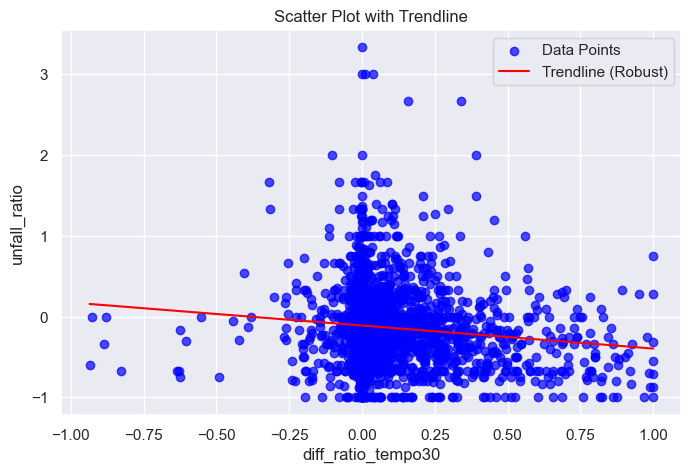

In [164]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Fit linear regression (robust alternative)
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean["diff_ratio_tempo30"], df_clean["unfall_ratio"])

# Scatter Plot
plt.figure(figsize=(8, 5))
plt.scatter(df_clean["diff_ratio_tempo30"], df_clean["unfall_ratio"], color='blue', alpha=0.7, label="Data Points")

# Plot the trendline
x_vals = np.linspace(df_clean["diff_ratio_tempo30"].min(), df_clean["diff_ratio_tempo30"].max(), 100)
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', label="Trendline (Robust)")

# Labels
plt.xlabel("diff_ratio_tempo30")
plt.ylabel("unfall_ratio")
plt.title("Scatter Plot with Trendline")
plt.legend()
plt.show()


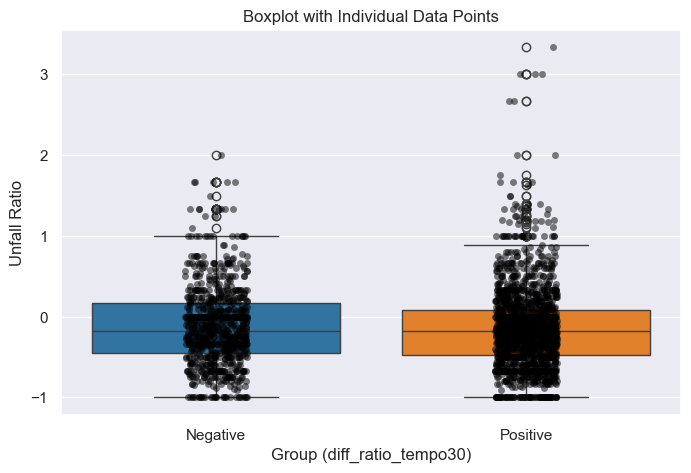

In [165]:
plt.figure(figsize=(8, 5))


# Create a new column to categorize the groups
df["group"] = df["diff_ratio_tempo30"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Boxplot with fixed palette
sns.boxplot(x="group", y="unfall_ratio", data=df, hue="group", palette=["#1f77b4", "#ff7f0e"], legend=False)

# Overlay jittered data points
sns.stripplot(x="group", y="unfall_ratio", data=df, color="black", alpha=0.5, jitter=True)

# Labels
plt.xlabel("Group (diff_ratio_tempo30)")
plt.ylabel("Unfall Ratio")
plt.title("Boxplot with Individual Data Points")

plt.show()


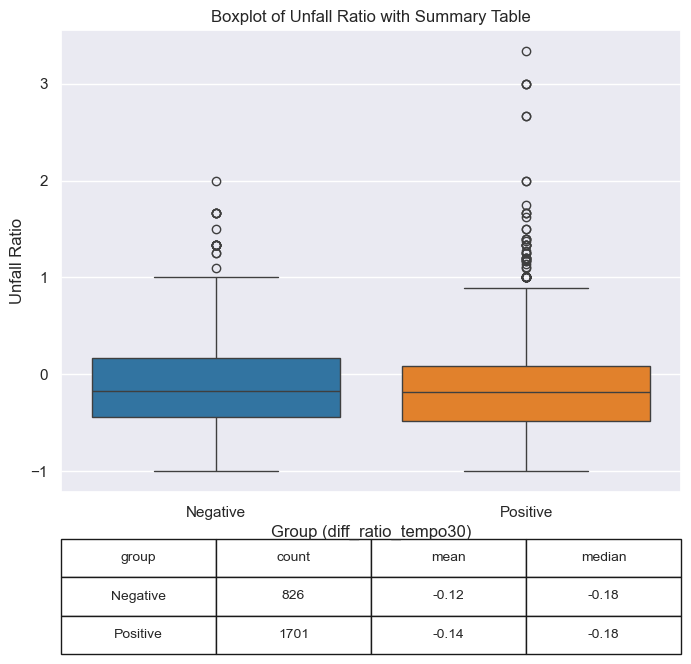

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a new column to categorize the groups
df["group"] = df["diff_ratio_tempo30"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Calculate summary statistics
summary = df.groupby("group")["unfall_ratio"].agg(["count", "mean", "median"]).reset_index()

# Create the boxplot
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(x="group", y="unfall_ratio", data=df, hue="group", palette=["#1f77b4", "#ff7f0e"], legend=False, ax=ax)

# Labels
plt.xlabel("Group (diff_ratio_tempo30)")
plt.ylabel("Unfall Ratio")
plt.title("Boxplot of Unfall Ratio with Summary Table")

# Create a table below the boxplot
table_data = summary.round(2)  # Round values for better readability
table = plt.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  bbox=[0, -0.35, 1, 0.25])  # Positioning the table

table.auto_set_font_size(False)
table.set_fontsize(10)

# Show the plot
plt.show()


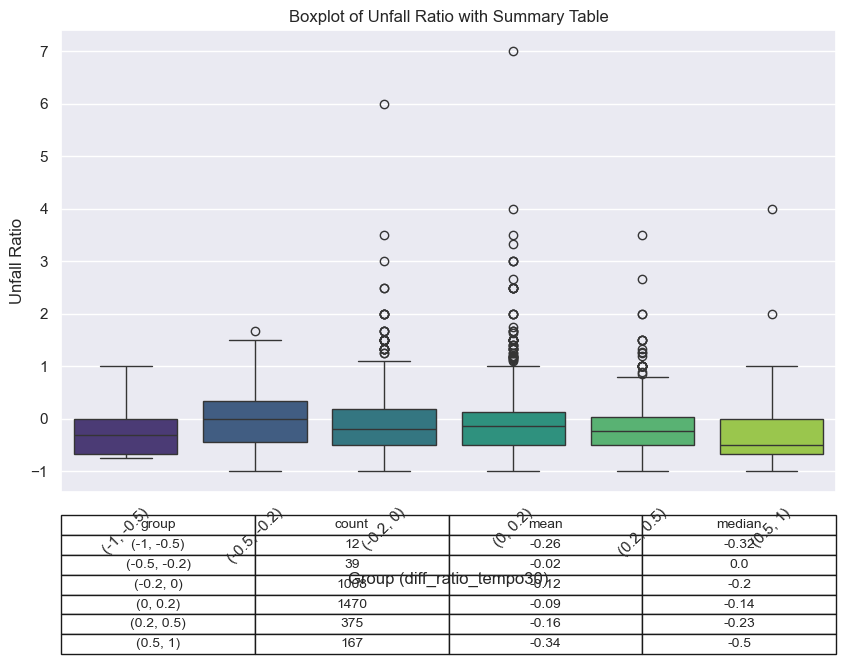

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define bins and labels
bins = [-1, -0.5, -0.2, 0, 0.2, 0.5, 1]  # Bin edges
labels = ["(-1, -0.5)", "(-0.5, -0.2)", "(-0.2, 0)", "(0, 0.2)", "(0.2, 0.5)", "(0.5, 1)"]  # Bin labels

# Create a new column categorizing the data into bins
#df["group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)
df.loc[:, "group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)

# Calculate summary statistics
#summary = df.groupby("group")["unfall_ratio"].agg(["count", "mean", "median"]).reset_index()
summary = df.groupby("group", observed=False)["unfall_ratio"].agg(["count", "mean", "median"]).reset_index()

# Create the boxplot
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(x="group", y="unfall_ratio", data=df, hue="group", palette="viridis", ax=ax)

# Labels
plt.xlabel("Group (diff_ratio_tempo30)")
plt.ylabel("Unfall Ratio")
plt.title("Boxplot of Unfall Ratio with Summary Table")

# Create a table below the boxplot
table_data = summary.round(2)  # Round values for better readability
table = plt.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  bbox=[0, -0.35, 1, 0.3])  # Positioning the table

table.auto_set_font_size(False)
table.set_fontsize(10)

# Show the plot
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()


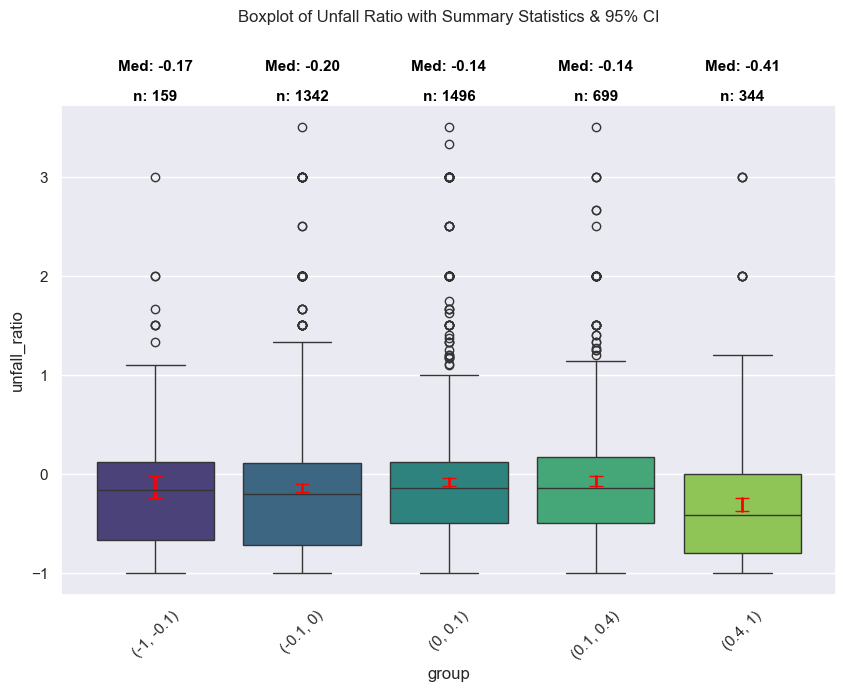

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme()


df = fin_join
df=df[df.vorher>=0].copy()
df=df[df.unfall_ratio<4]

# Define bins and labels for categorizing `diff_ratio_tempo30`
#bins = [-1, -0.2, 0, 0.2, 1]  # Bin edges
#labels = ["(-1, -0.2)", "(-0.2, 0)", "(0, 0.2)", "(0.2, 1)"]  # Bin labels

# Define bins and labels
#bins = [-1, -0.2, 0, 0.2, 0.5, 1]  # Bin edges
#labels = ["(-1, -0.2)", "(-0.2, 0)", "(0, 0.2)", "(0.2, 0.5)", "(0.5, 1)"]  # Bin labels

# Define bins and labels
bins = [-1, -0.1, 0, 0.1, 0.4, 1]  # Bin edges
labels = ["(-1, -0.1)", "(-0.1, 0)", "(0, 0.1)", "(0.1, 0.4)",  "(0.4, 1)"]  # Bin labels

# Create a new column categorizing the data into bins
#df["group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)
df.loc[:, "group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)

# Calculate summary statistics
#summary = df.groupby("group")["unfall_ratio"].agg(["count", "mean", "median", "std"]).reset_index()
summary = df.groupby("group", observed=False)["unfall_ratio"].agg(["count", "mean", "median","std"]).reset_index()

# **Compute 95% Confidence Interval**
summary["ci_lower"] = summary["mean"] - 1.96 * (summary["std"] / np.sqrt(summary["count"]))
summary["ci_upper"] = summary["mean"] + 1.96 * (summary["std"] / np.sqrt(summary["count"]))

# Create the boxplot
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(x="group", y="unfall_ratio", data=df, hue="group", palette="viridis", ax=ax)

# **Move title higher**
plt.title("Boxplot of Unfall Ratio with Summary Statistics & 95% CI", pad=60)

# **Set fixed Y-position for summary stats (closer to chart)**
y_position = ax.get_ylim()[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01  # Closer to plot

# **Spacing factor for better line separation**
line_spacing = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.03  # Adjust spacing between lines

# **Add Summary Statistics in multi-line format**
for i, row in summary.iterrows():
    x_pos = i  # X-axis position aligned with boxplot
    
    # Add count, mean, and median (each on a new line with improved spacing)
    ax.text(x_pos, y_position, f"n: {int(row['count'])}", ha='center', fontsize=11, fontweight="bold", color="black")
    #ax.text(x_pos, y_position + line_spacing, f"Mean: {row['mean']:.2f}", ha='center', fontsize=11, fontweight="bold", color="darkred")
    ax.text(x_pos, y_position + line_spacing * 2, f"Med: {row['median']:.2f}", ha='center', fontsize=11, fontweight="bold", color="black")

    # **Plot Confidence Interval (CI) as error bars**
    ax.plot([x_pos, x_pos], [row["ci_lower"], row["ci_upper"]], color="red", linewidth=2, marker="_", markersize=10)

# Adjust plot layout
plt.subplots_adjust(top=0.85, bottom=0.15)  # Moves title up, allows space below
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()


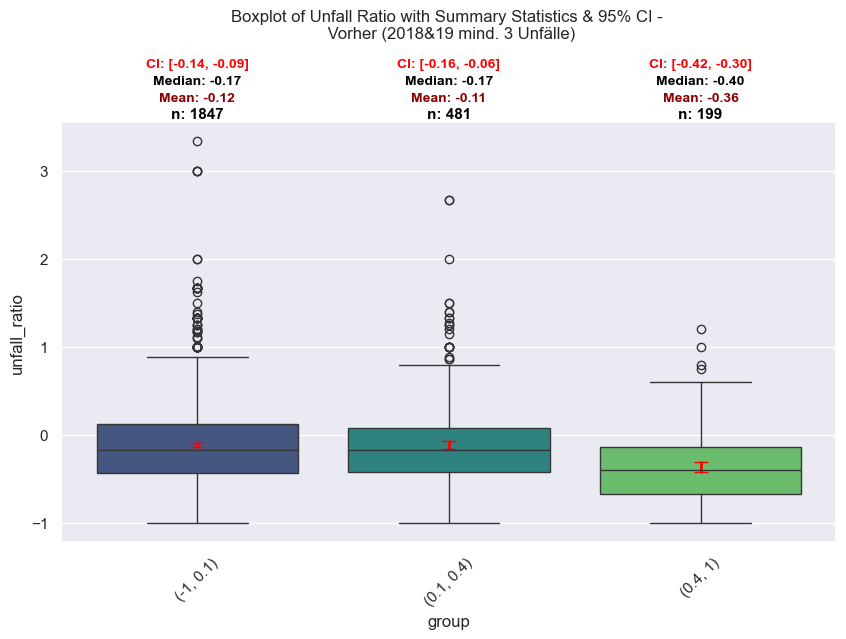

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme()


df = fin_join
df=df[df.vorher>=3].copy()
#df=df[df.unfall_ratio<4]

# Define bins and labels for categorizing `diff_ratio_tempo30`
#bins = [-1, -0.2, 0, 0.2, 1]  # Bin edges
#labels = ["(-1, -0.2)", "(-0.2, 0)", "(0, 0.2)", "(0.2, 1)"]  # Bin labels

# Define bins and labels
#bins = [-1, -0.2, 0, 0.2, 0.5, 1]  # Bin edges
#labels = ["(-1, -0.2)", "(-0.2, 0)", "(0, 0.2)", "(0.2, 0.5)", "(0.5, 1)"]  # Bin labels

# Define bins and labels
bins = [-1, 0.1, 0.4, 1]  # Bin edges
labels = ["(-1, 0.1)", "(0.1, 0.4)",  "(0.4, 1)"]  # Bin labels

# Create a new column categorizing the data into bins
#df["group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)
df.loc[:, "group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)

# Calculate summary statistics
#summary = df.groupby("group")["unfall_ratio"].agg(["count", "mean", "median", "std"]).reset_index()
summary = df.groupby("group", observed=False)["unfall_ratio"].agg(["count", "mean", "median","std"]).reset_index()

# **Compute 95% Confidence Interval**
summary["ci_lower"] = summary["mean"] - 1.96 * (summary["std"] / np.sqrt(summary["count"]))
summary["ci_upper"] = summary["mean"] + 1.96 * (summary["std"] / np.sqrt(summary["count"]))

# Create the boxplot
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(x="group", y="unfall_ratio", data=df, hue="group", palette="viridis", ax=ax)

# **Move title higher**
plt.title("Boxplot of Unfall Ratio with Summary Statistics & 95% CI - \n Vorher (2018 & 19 mind. 3 Unfälle)", pad=60)

# **Set fixed Y-position for summary stats (closer to chart)**
y_position = ax.get_ylim()[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01  # Closer to plot

# **Spacing factor for better line separation**
line_spacing = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.04  # Adjust spacing between lines

# **Add Summary Statistics in multi-line format**
for i, row in summary.iterrows():
    x_pos = i  # X-axis position aligned with boxplot
    
    # Add count, mean, and median (each on a new line with improved spacing)
    ax.text(x_pos, y_position, f"n: {int(row['count'])}", ha='center', fontsize=11, fontweight="bold", color="black")
    ax.text(x_pos, y_position + line_spacing, f"Mean: {row['mean']:.2f}", ha='center', fontsize=10, fontweight="bold", color="darkred")
    ax.text(x_pos, y_position + line_spacing * 2, f"Median: {row['median']:.2f}", ha='center', fontsize=10, fontweight="bold", color="black")
       
    # **Add CI below "n"**
    ci_text = f"CI: [{row['ci_lower']:.2f}, {row['ci_upper']:.2f}]"
    ax.text(x_pos, y_position + line_spacing * 3, ci_text, 
            ha='center', fontsize=10, fontweight="bold", color="red")

    # **Plot Confidence Interval (CI) as error bars**
    ax.plot([x_pos, x_pos], [row["ci_lower"], row["ci_upper"]], color="red", linewidth=2, marker="_", markersize=10)

# Adjust plot layout
plt.subplots_adjust(top=0.80, bottom=0.2)  # Moves title up, allows space below
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()


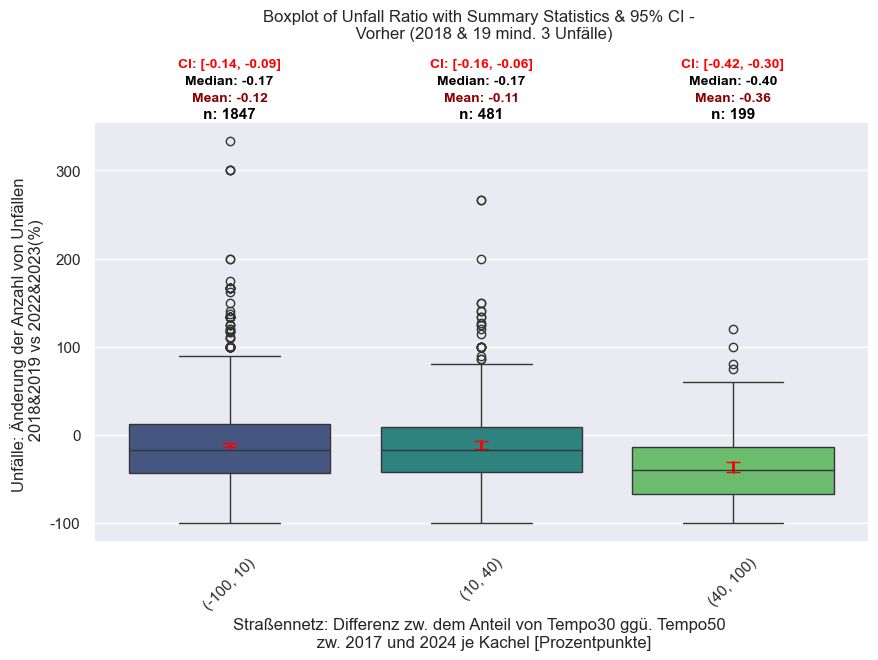

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme()


df = fin_join
df=df[df.vorher>=3].copy()
#df=df[df.unfall_ratio<4]

# Define bins and labels for categorizing `diff_ratio_tempo30`
#bins = [-1, -0.2, 0, 0.2, 1]  # Bin edges
#labels = ["(-1, -0.2)", "(-0.2, 0)", "(0, 0.2)", "(0.2, 1)"]  # Bin labels

# Define bins and labels
#bins = [-1, -0.2, 0, 0.2, 0.5, 1]  # Bin edges
#labels = ["(-1, -0.2)", "(-0.2, 0)", "(0, 0.2)", "(0.2, 0.5)", "(0.5, 1)"]  # Bin labels

# Define bins and labels
bins = [-1, 0.1, 0.4, 1]  # Bin edges
labels = ["(-100, 10)", "(10, 40)",  "(40, 100)"]  # Bin labels

# Create a new column categorizing the data into bins
#df["group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)
df.loc[:, "group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)

# Calculate summary statistics
#summary = df.groupby("group")["unfall_ratio"].agg(["count", "mean", "median", "std"]).reset_index()
summary = df.groupby("group", observed=False)["unfall_ratio"].agg(["count", "mean", "median","std"]).reset_index()

# **Compute 95% Confidence Interval**
summary["ci_lower"] = summary["mean"] - 1.96 * (summary["std"] / np.sqrt(summary["count"]))
summary["ci_upper"] = summary["mean"] + 1.96 * (summary["std"] / np.sqrt(summary["count"]))


# **Create the boxplot**
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(x="group", y="unfall_ratio", data=df, hue="group", palette="viridis", ax=ax)

# **Custom Axis Titles**
plt.xlabel("Straßennetz: Differenz zw. dem Anteil von Tempo30 ggü. Tempo50 \n zw. 2017 und 2024 je Kachel [Prozentpunkte]")  # Change X-axis title
plt.ylabel("Unfälle: Änderung der Anzahl von Unfällen \n 2018&2019 vs 2022&2023(%)")  # Change Y-axis title

# **Modify Y-axis tick labels to show values as integers multiplied by 100**
def format_ticks(y, _):
    return f"{int(y * 100)}"  # Convert to integer and multiply by 100

ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_ticks))

# **Move title higher**
plt.title("Boxplot of Unfall Ratio with Summary Statistics & 95% CI - \n Vorher (2018 & 19 mind. 3 Unfälle)", pad=60)

# **Set fixed Y-position for summary stats (closer to chart)**
y_position = ax.get_ylim()[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01  # Closer to plot

# **Spacing factor for better line separation**
line_spacing = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.04  # Adjust spacing between lines

# **Add Summary Statistics in multi-line format**
for i, row in summary.iterrows():
    x_pos = i  # X-axis position aligned with boxplot
    
    # Add count, mean, and median (each on a new line with improved spacing)
    ax.text(x_pos, y_position, f"n: {int(row['count'])}", ha='center', fontsize=11, fontweight="bold", color="black")
    ax.text(x_pos, y_position + line_spacing, f"Mean: {row['mean']:.2f}", ha='center', fontsize=10, fontweight="bold", color="darkred")
    ax.text(x_pos, y_position + line_spacing * 2, f"Median: {row['median']:.2f}", ha='center', fontsize=10, fontweight="bold", color="black")
       
    # **Add CI below "n"**
    ci_text = f"CI: [{row['ci_lower']:.2f}, {row['ci_upper']:.2f}]"
    ax.text(x_pos, y_position + line_spacing * 3, ci_text, 
            ha='center', fontsize=10, fontweight="bold", color="red")

    # **Plot Confidence Interval (CI) as error bars**
    ax.plot([x_pos, x_pos], [row["ci_lower"], row["ci_upper"]], color="red", linewidth=2, marker="_", markersize=10)

# Adjust plot layout
plt.subplots_adjust(top=0.80, bottom=0.2)  # Moves title up, allows space below
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()


In [70]:
### nur schere Unfälle

C:\Users\simon\AppData\Local\Temp\ipykernel_21628\3951314366.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("group")["unfall_ratio"].agg(["count", "mean", "median", "std"]).reset_index()
C:\Users\simon\AppData\Local\Temp\ipykernel_21628\3951314366.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="group", y="unfall_ratio", data=df, palette="viridis", ax=ax)


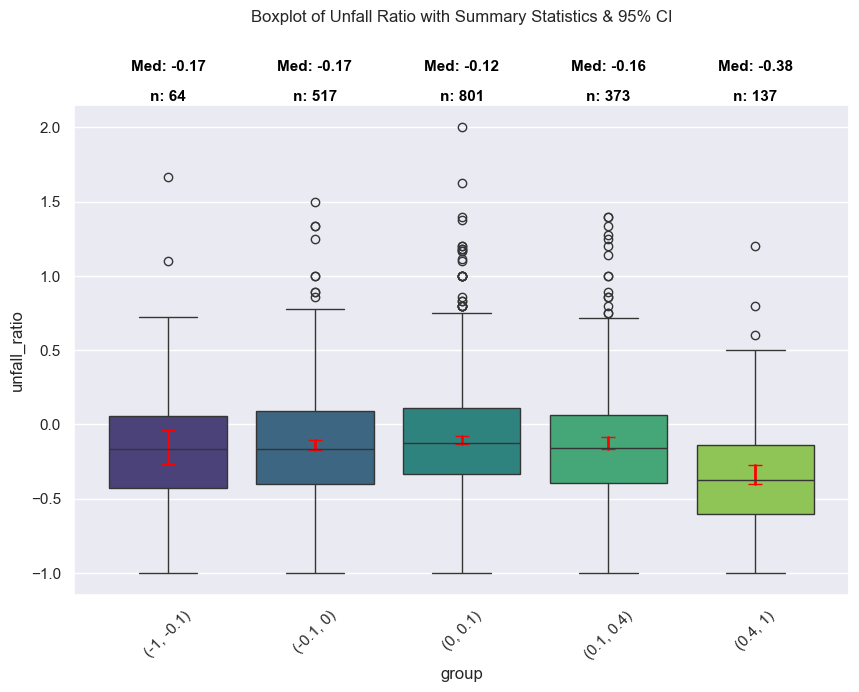

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme()

df = fin_join

df=df[df.vorher>=5]
df=df[df.unfall_ratio<4]

# Define bins and labels for categorizing `diff_ratio_tempo30`
#bins = [-1, -0.2, 0, 0.2, 1]  # Bin edges
#labels = ["(-1, -0.2)", "(-0.2, 0)", "(0, 0.2)", "(0.2, 1)"]  # Bin labels

# Define bins and labels
#bins = [-1, -0.2, 0, 0.2, 0.5, 1]  # Bin edges
#labels = ["(-1, -0.2)", "(-0.2, 0)", "(0, 0.2)", "(0.2, 0.5)", "(0.5, 1)"]  # Bin labels

# Define bins and labels
bins = [-1, -0.1, 0, 0.1, 0.4, 1]  # Bin edges
labels = ["(-1, -0.1)", "(-0.1, 0)", "(0, 0.1)", "(0.1, 0.4)", "(0.4, 1)"]  # Bin labels

# Create a new column categorizing the data into bins
df["group"] = pd.cut(df["diff_ratio_tempo30"], bins=bins, labels=labels, include_lowest=True)

# Calculate summary statistics
summary = df.groupby("group")["unfall_ratio"].agg(["count", "mean", "median", "std"]).reset_index()

# **Compute 95% Confidence Interval**
summary["ci_lower"] = summary["mean"] - 1.96 * (summary["std"] / np.sqrt(summary["count"]))
summary["ci_upper"] = summary["mean"] + 1.96 * (summary["std"] / np.sqrt(summary["count"]))

# Create the boxplot
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(x="group", y="unfall_ratio", data=df, palette="viridis", ax=ax)

# **Move title higher**
plt.title("Boxplot of Unfall Ratio with Summary Statistics & 95% CI", pad=60)

# **Set fixed Y-position for summary stats (closer to chart)**
y_position = ax.get_ylim()[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.01  # Closer to plot

# **Spacing factor for better line separation**
line_spacing = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.03  # Adjust spacing between lines

# **Add Summary Statistics in multi-line format**
for i, row in summary.iterrows():
    x_pos = i  # X-axis position aligned with boxplot
    
    # Add count, mean, and median (each on a new line with improved spacing)
    ax.text(x_pos, y_position, f"n: {int(row['count'])}", ha='center', fontsize=11, fontweight="bold", color="black")
    #ax.text(x_pos, y_position + line_spacing, f"Mean: {row['mean']:.2f}", ha='center', fontsize=11, fontweight="bold", color="darkred")
    ax.text(x_pos, y_position + line_spacing * 2, f"Med: {row['median']:.2f}", ha='center', fontsize=11, fontweight="bold", color="black")

    # **Plot Confidence Interval (CI) as error bars**
    ax.plot([x_pos, x_pos], [row["ci_lower"], row["ci_upper"]], color="red", linewidth=2, marker="_", markersize=10)

# Adjust plot layout
plt.subplots_adjust(top=0.85, bottom=0.15)  # Moves title up, allows space below
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()
